# *y-randomization* test

- We will use the `nk_rep_cross_validation_scrambling` function to perform *y-scrambling*.
- Five different percentages values of *y-scrambling* will be used:
    - 100%, 75%, 50%, 25%, and 0%

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')

In [2]:
# Load some auxiliary functions
%run ../../helper_modules/Helper_functions_for_nRepeats_x_kCV.ipynb

In [3]:
import warnings
warnings.filterwarnings('ignore')
# To avoid warnings related to `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.` 

In [4]:
%load_ext rpy2.ipython

### Load docking results

In [5]:
prot_name = 'hsp90'
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1).values
# Extract the response variable: Activity
y = df_dk_res['activity'].values

In [6]:
# Proportion of active molecules R_2
R_a = round(y.sum() / len(y), 4)

### Machine Learning Classifiers

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [8]:
from sklearn.linear_model import LogisticRegression 


hyparams = {'C':       1.0, 
            'penalty': 'l2', 
            'max_iter' :400}
lr = LogisticRegression(**hyparams)

In [9]:
from xgboost import XGBClassifier

hyparams = {'subsample': 0.5,
             'n_estimators': 500,
             'max_depth': 5,
             'learning_rate': 0.05,
             'gamma': 1,
             'colsample_bytree': 0.5,
             'alpha': 0.1,
             'eval_metric':   'logloss',
             'use_label_encoder': False
           }

xgb = XGBClassifier(**hyparams)

In [10]:
# ML Classifiers
ml_classifiers = {
    'ml_lr'  : lr,
    'ml_xgb' : xgb,
    'ml_dclf': dclf
}

### Consensus Strategies

In [11]:
from helper_modules.consensus_strategies import \
    get_mean_score, get_min_score, get_geom_mean_score

In [12]:
cs_functions = {
    'cs_MEAN': get_mean_score,
    'cs_GEOM': get_geom_mean_score,
    'cs_MIN' : get_min_score
}

### SBVS methods (estimators) dictionary

In [13]:
estimators = {**ml_classifiers, **cs_functions}

# Map new names for each VS method, for plotting
full_names = ['LR', 'GBT', 'DClf', 
              'csAVG', 'csGEO', 'csMIN']
sbvs_names = dict(zip(
    estimators.keys(),
    full_names))
sbvs_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_GEOM': 'csGEO',
 'cs_MIN': 'csMIN'}

### Evaluation metrics

In [14]:
metrics = dict(
    # AUC-ROC
    roc_auc   = {'metric_name': 'roc_auc'},
    # Normalized Enrichment Factor
    nef_05_Ra = {'metric_name': 'ef', 
                 'fraction'   : R_a, 
                 'method'     : 'normalized'}
    )

## *y-randomization* test

In [15]:
# Define an output directory to save the results
OUT_DIR = './cachedir/y_scrambling'

In [16]:
# Perform a 30x4-fold CV at each chi fraction
n_repeats = 30 # n
n_splits = 4   # k

# Set of chi fractions
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
# Dictionary of results
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    # filename to save the results as a python object
    filename = f'{OUT_DIR}/{evaluation_name}_{prot_name}_chi-{chi}'
    # Perform the y-randomization test
    result = nk_rep_cross_validation_scrambling(
                         filename   = filename, 
                         X = X, 
                         y = y,
                         random_chi = chi, 
                         estimators = estimators, 
                         metrics    = metrics, 
                         n_repeats  = n_repeats, 
                         n_splits   = n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result

File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_hsp90_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_hsp90_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_hsp90_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_hsp90_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_hsp90_chi-0.0
Fraction chi=0.0 finished.


## AUC-ROC Results

In [17]:
# Define a simple function to return a dataframe
# from the y_scrambling results
def get_y_rand_results(metric):
    df = get_group_stats(chi_results, 
                         metric_name = metric)
    df = df.replace(sbvs_names)
    df = df[df['method'].isin(full_names)]
    return df

In [18]:
# Get the dataframe
df_y_random = get_y_rand_results(metric = 'roc_auc')
df_y_random.head()

,index,method,mean,std
0,100,LR,0.511043,0.037569
1,75,LR,0.524405,0.035673
2,50,LR,0.609973,0.034494
3,25,LR,0.716300,0.030152
4,0,LR,0.819413,0.023228


R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Co

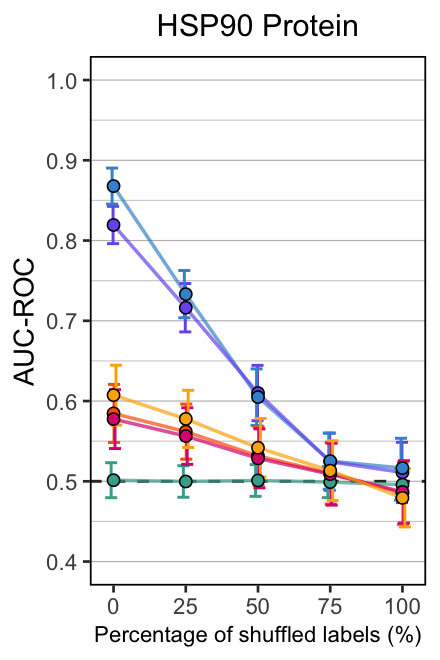

In [19]:
%%R -i df_y_random -i prot_name -w 2.2 -h 3.3 --units in -r 200
# Load the source file
source('../../R_scripts/plot_violinBox.R')
# Plot the AUC-ROC results
p = plot_lines(df_y_random, 
               cbbPalette  = cbbPalette, 
               point_size  = 1.8, 
               line_size   = 0.6, 
               switch_x    = FALSE,
               error_size  = 0.5, 
               error_dodge = 2, 
               color_column='method',
               error_width = 25) +
ggtitle(paste(toupper(prot_name), 'Protein'))


# Save the picture
metric = 'AUC-ROC'
methodology <- 'y-scrambling_all_features'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(prot_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

### Normalized EF

In [20]:
# Get the dataframe
df_y_random = get_y_rand_results(metric = 'nef_05_Ra')
df_y_random.head()

,index,method,mean,std
0,100,LR,0.115427,0.042465
1,75,LR,0.134910,0.035431
2,50,LR,0.229964,0.040822
3,25,LR,0.347887,0.045465
4,0,LR,0.473679,0.045944


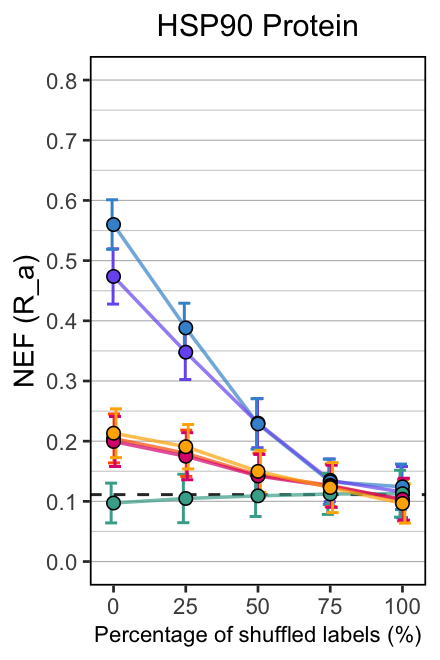

In [21]:
%%R -i df_y_random -i R_a -i prot_name -w 2.2 -h 3.3 --units in -r 200
# Load the source file
source('../../R_scripts/plot_violinBox.R')
# Plot the AUC-ROC results
p = plot_lines(df_y_random, 
               cbbPalette, 
               point_size  = 2., 
               line_size   = 0.6,
               error_size  = 0.5, 
               error_dodge = 2, 
               error_width = 25, 
               switch_x    = FALSE,
               y_min       = 0, 
               y_max       = 0.8, 
               base_h_line = R_a, 
               color_column='method',
               y_label     = 'NEF (R_a)') +
ggtitle(paste(toupper(prot_name), 'Protein'))


# Save the picture
metric = 'NEF'
methodology <- 'y-scrambling_all_features'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(prot_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## Save the y-scrambling results for statistical analysis

In [23]:
df_y_scrambling = pd.concat([df for df in chi_results.values()], 
                            keys = chi_results.keys())

# Format the table to simplify the analysis with R
# when combining all protein results and generate a single table to
# report in the supporting information material
df_y_scrambling.rename(sbvs_names, axis = 1, inplace = True)
df_y_scrambling.reset_index(inplace = True)
df_y_scrambling.rename({'level_0':'chi', 
                        'level_1':'metric', 
                        'level_2':'val_idx'}, 
                       inplace = True, axis = 1)
df_y_scrambling.replace('nef_05_Ra', 'nef', inplace = True)
df_y_scrambling = df_y_scrambling.melt(value_vars = sbvs_names.values(),
                                         id_vars = ['chi', 'metric', 'val_idx'],
                                         var_name = 'vs_method', 
                                         value_name = 'score')
# Save the results
filename = f'./y_scrambling_{prot_name}.csv'
df_y_scrambling.to_csv(filename)

Finished!